In [1]:
import sys
import os

In [2]:
import inspect
from hashlib import md5
from pathlib import Path
from operator import methodcaller
from itertools import chain
import datetime as dt
from functools import partial
from pprint import pprint  #as pp

In [3]:
from IPython.core.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from matplotlib import pyplot as plt

In [5]:
import click
import attr
from tqdm import tqdm
import numpy as np
from toolz import curry
import pandas as pd
import dask.array as da
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import Client

In [6]:
import binascii
import hashlib
def hash_utf8(string):
    """given utf8 string return md5 hash value as hex string"""
    hasher = hashlib.md5()
    hasher.update(string.encode("utf-8"))
    return binascii.hexlify(hasher.digest()).decode("utf-8")

In [7]:
import logging as log
log.disable(50)

In [8]:
from dask.distributed import LocalCluster
cluster = LocalCluster(processes=False)
client = Client(cluster)
client

Client Scheduler: inproc://192.168.1.70/416/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.32 GB


In [8]:
client = Client('127.0.0.1:36599')
client

Client Scheduler: tcp://127.0.0.1:36599 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 12.58 GB


In [9]:
n_workers = len(client.ncores())
n_cores = sum(client.ncores().values())
print(n_workers, n_cores)

4 8


In [32]:
bllb_path = str(Path(r"../../../code/python/bllb").resolve())
sys.path.insert(0, bllb_path)
from bllb_logging import *
from bllb import ppiter  #, hash_utf8

LOG_ON = False
LOG_LEVEL = "WARNING"  #"DEBUG"
def start_log(enable=True, lvl='WARNING', std_lib=True):
    log = setup_logging(enable, lvl, std_lib=std_lib)
    log.info('examinator logging started')
    return log
log_on = LOG_ON
log_level = LOG_LEVEL
log = start_log(log_on, log_level, std_lib=True)

In [11]:
def md5_blocks(path, blocksize=1024 * 2048) -> str:
    path = Path(path)
    if not path.is_dir():
        try:
            hasher = md5()
            with path.open('rb') as file:
                block = file.read(blocksize)
                while len(block) > 0:
                    hasher.update(block)
                    block = file.read(blocksize)
            return hasher.hexdigest()
        except Exception as error:
            log.warning(
                f'Error trying to hash item: {str(path)}\nError:\n{error}')
            return
    else:
        dbg(f'Item is a directory and will not be hashed.  {str(path)}')
        return
def glob_paths(path):
    try:
        path = Path(path)
        if path.is_dir():
            return path.rglob('*')
        else:
            return path
    except Exception as error:
        log.warning(error)

In [12]:
def get_stat(path, opt_md5=True, opt_pid=False) -> dict:
    log.debug(path)
    try:
        path = Path(path)
        info = dict([
            _ for _ in inspect.getmembers(path.lstat())
            if not _[0].startswith('_') and not inspect.isbuiltin(_[1])
        ])
        info.update(
            dict([
                (_[0], str(_[1])) for _ in inspect.getmembers(path)
                if '__' not in _[0] and '<' not in str(_[1])
            ]))
        info.update(
            dict([(str(_[0]), methodcaller(_[0])(path))
                  for _ in inspect.getmembers(path)
                  if _[0].startswith('is_') and _[0] != 'is_mount']))
        info['path'] = str(path)
        info['path_hash'] = hash_utf8(str(path))
        info['f_atime'] = dt.datetime.fromtimestamp(info['st_atime'])
        info['f_ctime'] = dt.datetime.fromtimestamp(info['st_ctime'])
        info['f_mtime'] = dt.datetime.fromtimestamp(info['st_mtime'])
        if opt_md5:
            if not path.is_dir():
                try:
                    md5_hash = md5_blocks(path)
                    info['md5'] = md5_hash
                except:
                    log.warning(f'Could not hash item: {str(path)}')
            else:
                log.debug(f'Item is a directory and will not be hashed.  {str(path)}'
                    )
        if opt_pid:
            log.debug(f"working using OS pid: {os.getpid()}, opt_pid: {opt_pid}")
        return info
    except Exception as error:
        log.warning(error)
        return {'path': str(path)}

In [13]:
path = Path('.')
get_stat(path)

{'n_fields': 19,
 'n_sequence_fields': 10,
 'n_unnamed_fields': 3,
 'st_atime': 1563120876.44357,
 'st_atime_ns': 1563120876443569800,
 'st_blksize': 16384,
 'st_blocks': 24,
 'st_ctime': 1563120876.44357,
 'st_ctime_ns': 1563120876443569800,
 'st_dev': 121,
 'st_gid': 0,
 'st_ino': 783,
 'st_mode': 16895,
 'st_mtime': 1563120876.44357,
 'st_mtime_ns': 1563120876443569800,
 'st_nlink': 2,
 'st_rdev': 0,
 'st_size': 12288,
 'st_uid': 0,
 '_closed': 'False',
 '_cparts': '[]',
 '_drv': '',
 '_parts': '[]',
 '_root': '',
 '_str': '.',
 'anchor': '',
 'drive': '',
 'name': '',
 'parent': '.',
 'parts': '()',
 'root': '',
 'stem': '',
 'suffix': '',
 'suffixes': '[]',
 'is_absolute': False,
 'is_block_device': False,
 'is_char_device': False,
 'is_dir': True,
 'is_fifo': False,
 'is_file': False,
 'is_reserved': False,
 'is_socket': False,
 'is_symlink': False,
 'path': '.',
 'path_hash': '5058f1af8388633f609cadb75a75dc9d',
 'f_atime': datetime.datetime(2019, 7, 14, 16, 14, 36, 443570),
 'f_

In [20]:
def flatten(lists):
    return reduce(lambda res, x: res + (flatten(x) if isinstance(x, list) else [x]), lists, [])

In [23]:
from functools import reduce

In [ ]:
%%time
basepaths = ['..']
opt_md5=False
#def proc_paths(basepaths, opt_md5=True):
"""proc_paths uses Dask client to map path_stat over basepaths."""
paths = chain.from_iterable(map(glob_paths, basepaths))
pstat = partial(get_stat, opt_md5=opt_md5, opt_pid=True)
results = client.map(pstat, paths)
data = [_.result() for _ in results]
ddf = dd.from_pandas(pd.DataFrame(data), npartitions=4)
df = ddf.compute()
#df['idx'] = df.index
#df['path_hash'] = df.path.map(str).map(hash_utf8)
#times = df.loc[:, ['idx', 'path', 'f_ctime', 'f_mtime', 'f_atime']].melt(id_vars=['idx', 'path'])

In [397]:
path = Path('..')
basepaths = [str(path)]
def proc_item(path):
    return [*map(str, path.iterdir())] + [*map(proc_item, filter(Path.is_dir, path.iterdir()))]
result = proc_item(path)
print(len([*path.rglob('*')]))
print(len(result))
results = [*result]
print(len(results))
final = flatten(results)
print(len(final))

507
34
34
507


In [24]:
def flatten(lists):
    return reduce(lambda res, x: res + (flatten(x.iterdir()) if x.is_dir() else [str(x)]), lists, [])
flatten(Path('.').iterdir())

['.ipynb_checkpoints/cli-checkpoint.py',
 '.ipynb_checkpoints/cli2-checkpoint.py',
 '.ipynb_checkpoints/examinator-checkpoint.py',
 '.ipynb_checkpoints/Examinator_testing-checkpoint.ipynb',
 '.ipynb_checkpoints/get_file_info-checkpoint.ipynb',
 '.ipynb_checkpoints/get_file_info-checkpoint.py',
 '.ipynb_checkpoints/get_file_info2-checkpoint.py',
 '.ipynb_checkpoints/get_file_info3-checkpoint.py',
 '.ipynb_checkpoints/scratch-checkpoint.ipynb',
 '.ipynb_checkpoints/script-checkpoint.py',
 '.ipynb_checkpoints/test_joblib-checkpoint.py',
 '.ipynb_checkpoints/untitled-checkpoint.py',
 'dask-worker-space/global.lock',
 'dask-worker-space/purge.lock',
 'daskerator.py',
 'examinator.py',
 'Examinator_testing.ipynb',
 'Examinator_testing.ipynb.py',
 'old/cli.py',
 'old/cli2.py',
 'old/examinator.py',
 'old/examinator2.py',
 'old/get_file_info.ipynb',
 'old/get_file_info.py',
 'old/get_file_info2.py',
 'old/script.py',
 'parquet/part.0.parquet',
 'parquet/part.1.parquet',
 'parquet/part.2.parque

In [432]:
is_iter = lambda item: item.is_dir()
rfunc = lambda res, x: res + (flatten(x.iterdir()) if is_iter(x) else [str(x)])
def flatten(iterator):
    return reduce(rfunc, iterator, [])
flatten(Path('.').iterdir())

['.ipynb_checkpoints/cli-checkpoint.py',
 '.ipynb_checkpoints/cli2-checkpoint.py',
 '.ipynb_checkpoints/examinator-checkpoint.py',
 '.ipynb_checkpoints/get_file_info-checkpoint.ipynb',
 '.ipynb_checkpoints/get_file_info-checkpoint.py',
 '.ipynb_checkpoints/get_file_info2-checkpoint.py',
 '.ipynb_checkpoints/scratch-checkpoint.ipynb',
 '.ipynb_checkpoints/script-checkpoint.py',
 '.ipynb_checkpoints/test_joblib-checkpoint.py',
 '.ipynb_checkpoints/Untitled-checkpoint.ipynb',
 '.ipynb_checkpoints/untitled-checkpoint.py',
 'cli.py',
 'cli2.py',
 'dask-worker-space/global.lock',
 'dask-worker-space/purge.lock',
 'dask-worker-space/worker-1ewi8jgm.dirlock',
 'dask-worker-space/worker-6iukt8s7.dirlock',
 'dask-worker-space/worker-7_r9up0f.dirlock',
 'daskerator.py',
 'examinator.py',
 'examinator2.py',
 'get_file_info.ipynb',
 'get_file_info.py',
 'get_file_info2.py',
 'get_file_info3.py',
 'scratch/.ipynb_checkpoints/asyncio_example-checkpoint.py',
 'scratch/.ipynb_checkpoints/ex_async-check

In [467]:
import operator
is_iter = lambda item: item.is_dir()
get_kids = lambda parent: parent.iterdir()
get_val = lambda item: flatten(get_kids(item)) if is_iter(item) else [item]
def flatten(iterator):
    results = []
    for i in iterator:
        results = partial(operator.add, results)(get_val(i))
    return results
[*flatten(Path('.').iterdir())]

[PosixPath('.ipynb_checkpoints/cli-checkpoint.py'),
 PosixPath('.ipynb_checkpoints/cli2-checkpoint.py'),
 PosixPath('.ipynb_checkpoints/examinator-checkpoint.py'),
 PosixPath('.ipynb_checkpoints/get_file_info-checkpoint.ipynb'),
 PosixPath('.ipynb_checkpoints/get_file_info-checkpoint.py'),
 PosixPath('.ipynb_checkpoints/get_file_info2-checkpoint.py'),
 PosixPath('.ipynb_checkpoints/scratch-checkpoint.ipynb'),
 PosixPath('.ipynb_checkpoints/script-checkpoint.py'),
 PosixPath('.ipynb_checkpoints/test_joblib-checkpoint.py'),
 PosixPath('.ipynb_checkpoints/Untitled-checkpoint.ipynb'),
 PosixPath('.ipynb_checkpoints/untitled-checkpoint.py'),
 PosixPath('cli.py'),
 PosixPath('cli2.py'),
 PosixPath('dask-worker-space/global.lock'),
 PosixPath('dask-worker-space/purge.lock'),
 PosixPath('dask-worker-space/worker-1ewi8jgm.dirlock'),
 PosixPath('dask-worker-space/worker-6iukt8s7.dirlock'),
 PosixPath('dask-worker-space/worker-7_r9up0f.dirlock'),
 PosixPath('daskerator.py'),
 PosixPath('examinato

In [25]:
def get_dir(d):
    path = Path(d)
    if path.is_dir():
        return [str(_) for _ in path.iterdir()]
get_dir('.')

['.ipynb_checkpoints',
 'dask-worker-space',
 'daskerator.py',
 'examinator.py',
 'Examinator_testing.ipynb',
 'Examinator_testing.ipynb.py',
 'old',
 'parquet',
 'root',
 'scratch',
 '__init__.py',
 '__pycache__',
 '~']

In [26]:
from queue import Queue
from threading import Thread

def multiplex(n, q, **kwargs):
    """ Convert one queue into several equivalent Queues

    >>> q1, q2, q3 = multiplex(3, in_q)
    """
    out_queues = [Queue(**kwargs) for i in range(n)]
    def f():
        while True:
            x = q.get()
            for out_q in out_queues:
                out_q.put(x)
    t = Thread(target=f)
    t.daemon = True
    t.start()
    return out_queues

def push(in_q, out_q):
    while True:
        x = in_q.get()
        out_q.put(x)

def merge(*in_qs, **kwargs):
    """ Merge multiple queues together

    >>> out_q = merge(q1, q2, q3)
    """
    out_q = Queue(**kwargs)
    threads = [Thread(target=push, args=(q, out_q)) for q in in_qs]
    for t in threads:
        t.daemon = True
        t.start()
    return out_q

# TODO:
- Progress display
 - Create additional copy q, thread func to count items in q
 - Terminate main loop and threads upon completion rather than count down/time out
 - itertoolz.count glob?
- Progress persistence, resumuption
- Result persistence, db storage

In [27]:
from queue import Queue
from threading import Thread
from time import sleep

In [35]:
q = Queue()
remote_q = client.scatter(q)
q1, q2 = multiplex(2, remote_q)
list_q = client.map(get_dir, q1)
l_q = client.gather(list_q)

opt_md5 = True

pstat = partial(get_stat, opt_md5=opt_md5, opt_pid=False)
q3 = client.map(pstat, q2)
q4, q5 = multiplex(2, q3)
result_q = client.gather(q4)

qs = [q, remote_q, q1, q2, list_q, l_q, q3, q4, result_q]

In [28]:
def load_dir(from_q, to_q, stop=False):
    limit = 300
    i = limit
    while True and ((i and not stop()) or from_q.qsize()):
        if from_q.qsize():
            l = from_q.get()
            if isinstance(l, list):
                for item in l:
                    to_q.put(item)
            i = min(i+1, limit)
        else:
            i -= 1
            sleep(.1)
    if stop():
        print('load_dir stopped.')
    elif not i:
        print('load_dir stopped by i')

In [29]:
def unloadq(q, stop, limit=2000, rest=.1, check=100):
    i = limit
    loops = 0
    results = []
    while True and ((i and not stop()) or q.qsize()):
        loops += 1
        if loops % check == 0:
            print(i, loops, len(results))
        if q.qsize():
            x = q.get()
            #print(x)
            results.append(x)
            i = min(i+1, limit)
        else:
            i -= 1
            if i % check == 0:
                print(i)
            sleep(rest)
    if stop():
        print('Unloadq stopped.')
    elif not i:
        print('Unloadq stopped by i')
    return results

In [ ]:
# Troubleshooting problem with thread not running

#from concurrent.futures import ThreadPoolExecutor
stop_threads = False
stop = lambda: stop_threads
basepaths = ['.']
#t = ThreadPoolExecutor()
thread = Thread(target=load_dir, args=(l_q, q, stop,), daemon = True)
thread.start()
i = 100
while (True or l_q.qsize()) and i:
    item = l_q.get()
    if item:
        i = min(i+1, 100)
    print(item)
    i = max(i-1, 0)
    if i % 10 == 0:
        print(l_q.qsize(), i)
    sleep(.1)
stop_threads = True

In [37]:
#load_thread = Thread(target=load_dir, args=(l_q, q,), daemon = True)
#load_thread.start()

from concurrent.futures import ThreadPoolExecutor
basepaths = ['.']
with ThreadPoolExecutor() as t:
    stop_threads = False
    stop = lambda: stop_threads
    t_load_dir = t.submit(load_dir, l_q, q, stop)
    print(t_load_dir.running())
    [q.put(str(Path(path).resolve())) for path in basepaths]
    #l_q.put(basepaths)
    results_future = t.submit(unloadq, result_q, stop, limit=300)
    ilimit = 10
    i = ilimit
    while True and i or alive:
        alive = sum([_q.qsize() for _q in qs])
        if alive:
            i = min(i+1, ilimit)
            print(alive, i)
            print(t_load_dir.running())
        else:
            i -= 1
            print(f'i: {i}')
        sleep(.1)
    stop_threads = True
    #results_list = unloadq(result_q, limit=300)
    results_list = results_future.result()
    results = pd.DataFrame(results_list)
    print(results.info())
#t.shutdown(False)
#del(load_thread)
print(q5.qsize())

True


[None]

i: 9
i: 8
23 9
True


Exception in thread Threaded gather():
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/distributed/client.py", line 1747, in _threaded_gather
    results = self.gather(L, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/distributed/client.py", line 1822, in gather
    asynchronous=asynchronous,
  File "/opt/conda/lib/python3.6/site-packages/distributed/client.py", line 753, in sync
    return sync(self.loop, func, *args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/distributed/utils.py", line 331, in sync
    six.reraise(*error[0])
  File "/opt/conda/lib/python3.6/site-packages/six.py", line 693, in reraise
    raise value
  File "/opt/conda/lib/python3.6/site-packages/distributed/utils.py", line 316, in f
    result[0] = yield futu

25 10
True
48 10
True
48 10
True
48 10
True
48 10
True
67 10
True
67 10
True
87 10
True
83 10
True
102 10
True
99 10
True
94 10
True
89 10
True
84 10
True
79 10
True
86 10
True
85 10
True
82 10
True
79 10
True
79 10
True
78 10
True
75 10
True
76 10
True
74 10
True
73 10
True
72 10
True
73 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
True
71 10
Tru

KeyboardInterrupt: 

In [36]:
[_q.qsize() for _q in qs]

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Attempting to utilize Dask df to handle, export data

def iterq(q):
    while q.qsize():
        yield q.get()

print(q5.qsize())
result_count = q5.qsize()
data = client.gather(q5)
while data.qsize() < result_count:
    print('sleeping')
    sleep(.1)
print(data.qsize())
iterdata = [*iterq(data)]
print(len(iterdata))
df = pd.DataFrame(iterdata)
print(len(df))
ddf = dd.from_pandas(df, npartitions=4)
remote_ddf = client.scatter(ddf)
remote_result = remote_ddf.result()
remote_result.to_csv('./export4-*.csv')
new_ddf = dd.read_csv('./export4-*.csv')
new_ddf.compute()

In [16]:
%time
from toolz import itertoolz
print(itertoolz.count(Path('../..').rglob('*')))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs
26299


47
['id', 'name', '_str', 'drive', 'st_mtime', '_cparts', 'parent', 'parts', 'st_atime', 'is_file', 'is_fifo', 'st_blocks', 'st_ctime', 'is_dir', 'st_mode', 'st_ino', '_root', 'root', 'md5', 'st_dev', 'st_uid', 'is_char_device', 'suffix', 'is_socket', 'n_sequence_fields', 'path', 'is_block_device', '_parts', '_closed', 'anchor', 'path_hash', 'st_gid', 'is_reserved', 'n_fields', 'is_symlink', 'n_unnamed_fields', 'stem', 'st_ctime_ns', 'suffixes', '_drv', 'st_atime_ns', 'is_absolute', 'st_blksize', 'st_size', 'st_rdev', 'st_mtime_ns', 'st_nlink']
Index(['id', 'name', '_str', 'drive', 'st_mtime', '_cparts', 'parent', 'parts',
       'st_atime', 'is_file', 'is_fifo', 'st_blocks', 'st_ctime', 'is_dir',
       'st_mode', 'st_ino', '_root', 'root', 'md5', 'st_dev', 'st_uid',
       'is_char_device', 'suffix', 'is_socket', 'n_sequence_fields', 'path',
       'is_block_device', '_parts', '_closed', 'anchor', 'path_hash', 'st_gid',
       'is_reserved', 'n_fields', 'is_symlink', 'n_unnamed_field

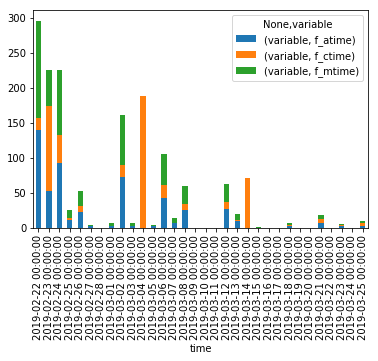

In [24]:
times = ['f_ctime', 'f_mtime', 'f_atime']
results.index.name = 'id'
results['id'] = results.index
cols = list(set(results.columns) - set(times))
print(len(cols))
print(cols)
stacked = pd.melt(results, id_vars=cols, value_vars=times, value_name='time').set_index('time')
print(stacked.columns)
unstacked = stacked.loc[:, ['variable']].groupby('variable').resample('D').count().unstack('variable')
unstacked.plot(kind='bar', stacked=True)

In [26]:
len(os.listdir('..'))
os.listdir('..')

25

['.bak.gitignore',
 '.editorconfig',
 '.git',
 '.github',
 '.gitignore',
 '.ipynb_checkpoints',
 '.mypy_cache',
 '.travis.yml',
 '.vs',
 '.vscode',
 'CONTRIBUTING.rst',
 'docs',
 'examinator',
 'examinator.code-workspace',
 'examinator_notes.md',
 'HISTORY.rst',
 'LICENSE',
 'Makefile',
 'MANIFEST.in',
 'README.rst',
 'requirements_dev.txt',
 'setup.cfg',
 'setup.py',
 'tests',
 'tox.ini']

In [131]:
def r_listdir(src):
    names = os.listdir(src)
    results = []
    for name in names:
        srcname = os.path.join(src, name)
        if os.path.isdir(srcname):
            results.extend(r_listdir(srcname))
        else:
            results.append(srcname)
    return results
len(r_listdir('.'))

54

In [33]:
len([*os.scandir('..')])

25

In [78]:
def r_scandir(src):
    names = os.scandir(src)
    results = []
    for name in names:
        if os.path.isdir(name):
            results += r_scandir(name)
        else:
            results.append(name.path)
    return results
len(r_scandir('.'))

54

In [34]:
import glob

In [91]:
results = glob.glob('**/?*', recursive=True)
len(results)
results

41

['cli.py',
 'cli2.py',
 'dask-worker-space',
 'daskerator.py',
 'examinator.py',
 'examinator2.py',
 'Examinator_testing.ipynb',
 'get_file_info.ipynb',
 'get_file_info.py',
 'get_file_info2.py',
 'get_file_info3.py',
 'parquet',
 'scratch',
 'script.py',
 'test_joblib.py',
 'Untitled-1.py',
 'untitled.py',
 '__init__.py',
 '__pycache__',
 '~',
 'dask-worker-space/global.lock',
 'dask-worker-space/purge.lock',
 'parquet/part.0.parquet',
 'parquet/part.1.parquet',
 'parquet/part.2.parquet',
 'parquet/part.3.parquet',
 'scratch/asyncio_example.py',
 'scratch/ex_async.py',
 'scratch/loguru_issue.py',
 'scratch/scratch.ipynb',
 'scratch/test_q.py',
 'scratch/test_threading.py',
 '__pycache__/examinator.cpython-36.pyc',
 '__pycache__/examinator.cpython-37.pyc',
 '__pycache__/examinator.cpython-38.pyc',
 '__pycache__/examinator2.cpython-36.pyc',
 '__pycache__/examinator2.cpython-37.pyc',
 '__pycache__/get_file_info.cpython-36.pyc',
 '__pycache__/get_file_info.cpython-37.pyc',
 '__pycache__/g

In [124]:
from os import walk

def r_walk(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend([os.path.join(dirpath, name) for name in filenames])
    return f
results = r_walk('.')
len(results)
results

54

['./cli.py',
 './cli2.py',
 './daskerator.py',
 './examinator.py',
 './examinator2.py',
 './Examinator_testing.ipynb',
 './get_file_info.ipynb',
 './get_file_info.py',
 './get_file_info2.py',
 './get_file_info3.py',
 './script.py',
 './test_joblib.py',
 './Untitled-1.py',
 './untitled.py',
 './__init__.py',
 './.ipynb_checkpoints/cli-checkpoint.py',
 './.ipynb_checkpoints/cli2-checkpoint.py',
 './.ipynb_checkpoints/examinator-checkpoint.py',
 './.ipynb_checkpoints/Examinator_testing-checkpoint.ipynb',
 './.ipynb_checkpoints/get_file_info-checkpoint.ipynb',
 './.ipynb_checkpoints/get_file_info-checkpoint.py',
 './.ipynb_checkpoints/get_file_info2-checkpoint.py',
 './.ipynb_checkpoints/scratch-checkpoint.ipynb',
 './.ipynb_checkpoints/script-checkpoint.py',
 './.ipynb_checkpoints/test_joblib-checkpoint.py',
 './.ipynb_checkpoints/untitled-checkpoint.py',
 './dask-worker-space/global.lock',
 './dask-worker-space/purge.lock',
 './parquet/part.0.parquet',
 './parquet/part.1.parquet',
 './pa

In [57]:
import fnmatch

In [128]:
def r_path(path):
    return [str(_) for _ in Path(path).rglob('*') if not _.is_dir()]
len(r_path('.'))

54

In [136]:
path = '/data/OneDrive/Documents/projects/bookmarks/'
%timeit len(r_listdir(path))
%timeit len(r_scandir(path))
%timeit len(r_walk(path))
%timeit len(r_path(path))

5.68 s ± 548 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.76 s ± 1.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.02 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.2 s ± 808 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
path = '../..'
rw_set = set(r_walk(path))
len(rw_set)
rp_set = set(r_path(path))
len(rp_set)

28972

48825

In [125]:
rw = r_walk(path)
len(rw)
rw_set = set(rw)
len(rw_set)

48827

48827

In [129]:
rp = r_path(path)
len(rp)
rp_set = set(rp)
len(rp_set)

48827

48827

In [116]:
%time len(set(r_listdir(path)))
%time len(set(r_scandir(path)))

CPU times: user 1.48 s, sys: 1.97 s, total: 3.45 s
Wall time: 12.5 s


48827

CPU times: user 1.21 s, sys: 2.01 s, total: 3.22 s
Wall time: 12.4 s


48827

In [117]:
rl = r_listdir(path)
rl_set = set(rl)
len(rl_set)
rs = r_scandir(path)
rs_set = set(rs)
len(rs_set)

48827

48827

In [127]:
rw_set - rp_set

{'../../gym/gym-retro/third-party/capnproto/c++/ekam-provider/c++header',
 '../../gym/gym-retro/third-party/capnproto/c++/ekam-provider/canonical'}

In [137]:
mypath = '.'
_, _, filenames = next(walk(mypath), (None, None, []))
len(filenames)
filenames

15

['cli.py',
 'cli2.py',
 'daskerator.py',
 'examinator.py',
 'examinator2.py',
 'Examinator_testing.ipynb',
 'get_file_info.ipynb',
 'get_file_info.py',
 'get_file_info2.py',
 'get_file_info3.py',
 'script.py',
 'test_joblib.py',
 'Untitled-1.py',
 'untitled.py',
 '__init__.py']

In [139]:
(_, _, filenames) = next(os.walk(mypath))
len(filenames)
filenames

15

['cli.py',
 'cli2.py',
 'daskerator.py',
 'examinator.py',
 'examinator2.py',
 'Examinator_testing.ipynb',
 'get_file_info.ipynb',
 'get_file_info.py',
 'get_file_info2.py',
 'get_file_info3.py',
 'script.py',
 'test_joblib.py',
 'Untitled-1.py',
 'untitled.py',
 '__init__.py']